# DATA EXPLORATION


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest

sns.set(style="whitegrid")

In [37]:
df = pd.read_csv('../data/raw/creditcard.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [38]:
classes = df['Class'].value_counts().to_dict()
porcentage_of_fraud = (100 * classes[1]) / df.shape[0]

print('% of fraudulent transactions: {:.4f}%'.format(porcentage_of_fraud))

% of fraudulent transactions: 0.1727%


In [39]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (data[column] < lower) | (data[column] > upper)
    return mask

outliers_amount = detect_outliers_iqr(df, 'Amount')
outliers_time = detect_outliers_iqr(df, 'Time')

df['outlier_iqr'] = (outliers_amount | outliers_time).astype(int)

print(f"🔹 Outliers detectados por IQR: {df['outlier_iqr'].sum()} / {len(df)} ({df['outlier_iqr'].mean()*100:.3f}%)")

🔹 Outliers detectados por IQR: 31904 / 284807 (11.202%)


In [40]:
iso = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # asumimos 1% de anomalías
    random_state=42,
    n_jobs=-1
)

# Solo variables numéricas
X = df.drop(columns=['Class', 'outlier_iqr'])
df['outlier_iso'] = (iso.fit_predict(X) == -1).astype(int)

print(f"🔹 Outliers detectados por Isolation Forest: {df['outlier_iso'].sum()} / {len(df)} ({df['outlier_iso'].mean()*100:.3f}%)")

c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


🔹 Outliers detectados por Isolation Forest: 2849 / 284807 (1.000%)


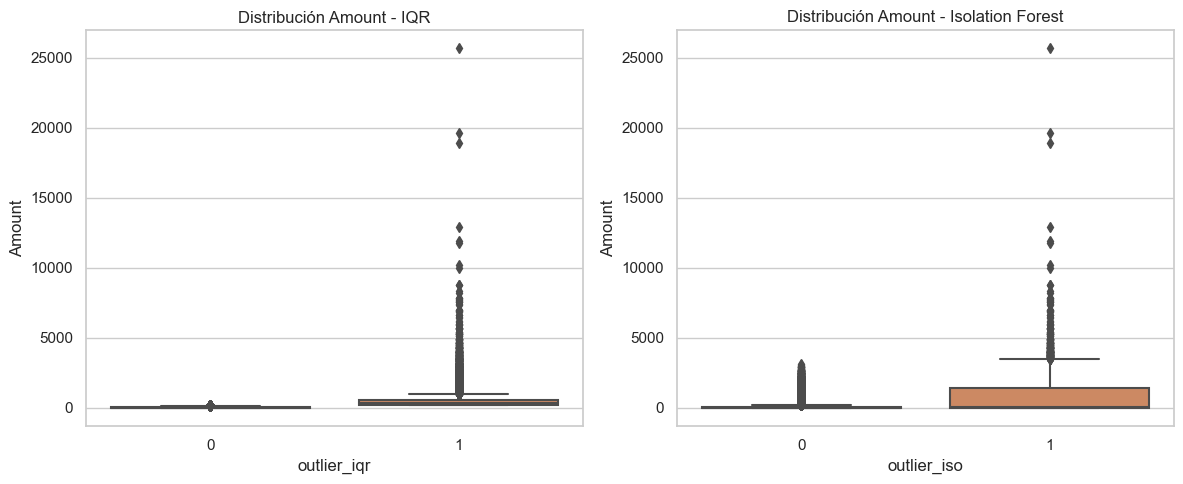

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(x='outlier_iqr', y='Amount', data=df, ax=axs[0])
axs[0].set_title('Distribución Amount - IQR')

sns.boxplot(x='outlier_iso', y='Amount', data=df, ax=axs[1])
axs[1].set_title('Distribución Amount - Isolation Forest')

plt.tight_layout()
plt.show()

In [42]:
comparison = pd.crosstab(df['outlier_iqr'], df['outlier_iso'], rownames=['IQR'], colnames=['Isolation Forest'])
print("\n🔍 Tabla comparativa de coincidencias:")
print(comparison)

# Porcentaje de coincidencia entre ambos métodos
match = (df['outlier_iqr'] == df['outlier_iso']).mean() * 100
print(f"\nCoincidencia entre métodos: {match:.2f}%")

# Distribución general
print("\nResumen de columnas de outliers:")
print(df[['outlier_iqr', 'outlier_iso']].mean().rename('Proporción'))


🔍 Tabla comparativa de coincidencias:
Isolation Forest       0     1
IQR                           
0                 251227  1676
1                  30731  1173

Coincidencia entre métodos: 88.62%

Resumen de columnas de outliers:
outlier_iqr    0.112020
outlier_iso    0.010003
Name: Proporción, dtype: float64


In [43]:
df['is_anomaly'] = df['outlier_iso']

In [44]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,outlier_iqr,outlier_iso,is_anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0,1,1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0,0,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0,0,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0,0,0


In [80]:
asd = df.iloc[0:284700].drop(columns=['is_anomaly'], inplace=False)
asd.to_csv("train_data.csv", index=False)
# df_test = df.iloc[284700::]
# df_test.drop(columns=['is_anomaly'], inplace=True)
# df_test

C:\Users\pipea\AppData\Local\Temp\ipykernel_34684\3966467180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:284700].drop(columns=['is_anomaly'], inplace=True).to_csv("train_data.csv", index=False)


AttributeError: 'NoneType' object has no attribute 'to_csv'

In [78]:
df_test.to_csv("test_data.csv", index=False)

In [45]:
df['is_anomaly'].value_counts(normalize=True)

0    0.989997
1    0.010003
Name: is_anomaly, dtype: float64

In [57]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0


In [46]:
df = df.drop(columns=['outlier_iqr', 'outlier_iso'])

In [47]:
from sklearn.preprocessing import StandardScaler

# Excluir columnas no numéricas o etiquetas
X = df.drop(columns=['Class', 'is_anomaly'])  # ajusta según tus columnas
y = df['Class']  # o la etiqueta real

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [60]:
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['Class'] = y.values
df_scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,is_anomaly,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,-0.100520,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,-0.100520,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,-0.100520,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,-0.100520,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,-0.100520,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.641931,-6.065842,6.099286,-6.486245,-1.459641,-3.886611,-1.956690,-3.975628,6.116573,1.742559,...,0.154146,1.624574,-0.841000,2.756320,0.518500,2.337901,2.495529,-0.350151,9.948234,0
284803,1.641952,-0.374121,-0.033356,1.342145,-0.521651,0.629040,0.794446,0.019667,0.246886,0.532299,...,1.273781,0.019958,-1.677920,-1.163726,-0.819647,0.169641,-0.162164,-0.254117,-0.100520,0
284804,1.641974,0.980024,-0.182434,-2.143205,-0.393984,1.905833,2.275262,-0.239939,0.593140,0.393630,...,0.796788,-0.060053,1.056944,0.509797,-0.181182,0.011037,-0.080467,-0.081839,-0.100520,0
284805,1.641974,-0.122755,0.321250,0.463320,0.487192,-0.273836,0.468155,-0.554672,0.568631,0.356887,...,1.102451,-0.261503,0.203428,-1.091855,1.133635,0.269604,0.316687,-0.313249,-0.100520,0


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,        # 70% entrenamiento, 30% prueba
    stratify=y,           # mantiene la proporción de clases
    random_state=42
)

In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Antes del balanceo:", y_train.value_counts(normalize=True))
print("Después del balanceo:", y_train_res.value_counts(normalize=True))

Antes del balanceo: 0    0.998275
1    0.001725
Name: Class, dtype: float64
Después del balanceo: 0    0.5
1    0.5
Name: Class, dtype: float64



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443



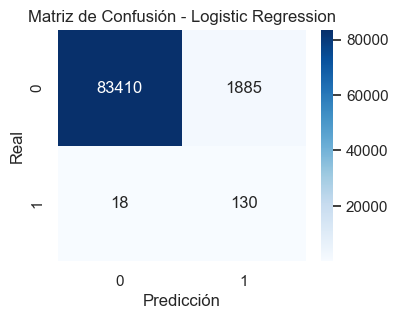


=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.71      0.46       148

    accuracy                           1.00     85443
   macro avg       0.67      0.85      0.73     85443
weighted avg       1.00      1.00      1.00     85443



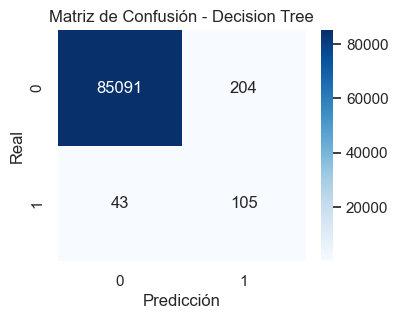


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



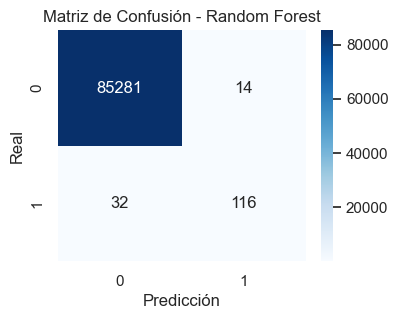

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Model": name,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"],
        "ROC-AUC": auc
    })
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


In [51]:

df_results = pd.DataFrame(results)
print("\n📊 Comparativa de modelos base:")
display(df_results.sort_values(by="F1-Score", ascending=False))


📊 Comparativa de modelos base:


,Model,Precision,Recall,F1-Score,ROC-AUC
2,Random Forest,0.892308,0.783784,0.834532,0.962471
1,Decision Tree,0.339806,0.709459,0.459519,0.853534
0,Logistic Regression,0.064516,0.878378,0.120203,0.967062


In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Modelos base
models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# DataFrame para resultados
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append((name, precision, recall, f1, accuracy, auc))

# Mostrar resultados ordenados por F1
import pandas as pd
df_results = pd.DataFrame(results, columns=["Modelo", "Precision", "Recall", "F1", "Accuracy", "ROC_AUC"])
df_results = df_results.sort_values(by="F1", ascending=False)
print(df_results)

c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              Modelo  Precision    Recall        F1  Accuracy   ROC_AUC
1            XGBoost   0.942623  0.777027  0.851852  0.999532  0.972955
3           CatBoost   0.949153  0.756757  0.842105  0.999508  0.969470
2           LightGBM   0.263610  0.621622  0.370221  0.996337  0.772184
0  Gradient Boosting   0.727273  0.162162  0.265193  0.998443  0.344591


In [55]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import make_scorer, f1_score

# Modelo base
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Estimamos el peso de la clase positiva
pos_weight = sum(y_train==0)/sum(y_train==1)

param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10),
    'scale_pos_weight': Real(1, pos_weight, 'log-uniform')  # rango válido
}

# Métrica a optimizar
f1_scorer = make_scorer(f1_score)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=50,           # número de iteraciones
    scoring=f1_scorer,   # optimizamos F1
    cv=3,
    n_jobs=1,
    random_state=42,
    verbose=2
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y parámetros
print("Mejores parámetros:", opt.best_params_)
print("Mejor F1 en CV:", opt.best_score_)

c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.11883357504897696, max_depth=10, min_child_weight=4, n_estimators=703, scale_pos_weight=13.92950715293977, subsample=0.7403725339596576; total time=  32.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.11883357504897696, max_depth=10, min_child_weight=4, n_estimators=703, scale_pos_weight=13.92950715293977, subsample=0.7403725339596576; total time=  37.8s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.11883357504897696, max_depth=10, min_child_weight=4, n_estimators=703, scale_pos_weight=13.92950715293977, subsample=0.7403725339596576; total time=  29.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.2017268796559709, max_depth=5, min_child_weight=10, n_estimators=878, scale_pos_weight=1.486378524060676, subsample=0.65532341531143; total time=  28.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.2017268796559709, max_depth=5, min_child_weight=10, n_estimators=878, scale_pos_weight=1.486378524060676, subsample=0.65532341531143; total time=  27.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.2017268796559709, max_depth=5, min_child_weight=10, n_estimators=878, scale_pos_weight=1.486378524060676, subsample=0.65532341531143; total time=  27.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.7779330049204607, learning_rate=0.22754356809600707, max_depth=4, min_child_weight=5, n_estimators=269, scale_pos_weight=17.91336376639898, subsample=0.6621792216202174; total time=  12.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.7779330049204607, learning_rate=0.22754356809600707, max_depth=4, min_child_weight=5, n_estimators=269, scale_pos_weight=17.91336376639898, subsample=0.6621792216202174; total time=  12.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.7779330049204607, learning_rate=0.22754356809600707, max_depth=4, min_child_weight=5, n_estimators=269, scale_pos_weight=17.91336376639898, subsample=0.6621792216202174; total time=  12.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9249583953429453, learning_rate=0.01794217698903441, max_depth=7, min_child_weight=8, n_estimators=571, scale_pos_weight=1.8351818643032638, subsample=0.9023202131343526; total time=  52.8s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9249583953429453, learning_rate=0.01794217698903441, max_depth=7, min_child_weight=8, n_estimators=571, scale_pos_weight=1.8351818643032638, subsample=0.9023202131343526; total time=  50.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9249583953429453, learning_rate=0.01794217698903441, max_depth=7, min_child_weight=8, n_estimators=571, scale_pos_weight=1.8351818643032638, subsample=0.9023202131343526; total time=  45.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9198213766428692, learning_rate=0.04436313425678925, max_depth=7, min_child_weight=7, n_estimators=913, scale_pos_weight=95.64947625623438, subsample=0.7696712289842729; total time=  57.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9198213766428692, learning_rate=0.04436313425678925, max_depth=7, min_child_weight=7, n_estimators=913, scale_pos_weight=95.64947625623438, subsample=0.7696712289842729; total time=  57.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9198213766428692, learning_rate=0.04436313425678925, max_depth=7, min_child_weight=7, n_estimators=913, scale_pos_weight=95.64947625623438, subsample=0.7696712289842729; total time=  52.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8936112071942273, learning_rate=0.24409731675583402, max_depth=4, min_child_weight=3, n_estimators=820, scale_pos_weight=10.69526089063092, subsample=0.7836098056603222; total time=  23.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8936112071942273, learning_rate=0.24409731675583402, max_depth=4, min_child_weight=3, n_estimators=820, scale_pos_weight=10.69526089063092, subsample=0.7836098056603222; total time=  23.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8936112071942273, learning_rate=0.24409731675583402, max_depth=4, min_child_weight=3, n_estimators=820, scale_pos_weight=10.69526089063092, subsample=0.7836098056603222; total time=  23.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8468317434009265, learning_rate=0.1397356450670215, max_depth=6, min_child_weight=9, n_estimators=633, scale_pos_weight=43.907800733006816, subsample=0.8595110038814904; total time=  24.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8468317434009265, learning_rate=0.1397356450670215, max_depth=6, min_child_weight=9, n_estimators=633, scale_pos_weight=43.907800733006816, subsample=0.8595110038814904; total time=  23.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8468317434009265, learning_rate=0.1397356450670215, max_depth=6, min_child_weight=9, n_estimators=633, scale_pos_weight=43.907800733006816, subsample=0.8595110038814904; total time=  22.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.817361227076125, learning_rate=0.22854155758290642, max_depth=6, min_child_weight=9, n_estimators=392, scale_pos_weight=1.3843660335623842, subsample=0.8283111210715592; total time=  12.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.817361227076125, learning_rate=0.22854155758290642, max_depth=6, min_child_weight=9, n_estimators=392, scale_pos_weight=1.3843660335623842, subsample=0.8283111210715592; total time=  12.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.817361227076125, learning_rate=0.22854155758290642, max_depth=6, min_child_weight=9, n_estimators=392, scale_pos_weight=1.3843660335623842, subsample=0.8283111210715592; total time=  12.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9821911945239713, learning_rate=0.10836844143838541, max_depth=9, min_child_weight=5, n_estimators=443, scale_pos_weight=3.8370528279179346, subsample=0.6000244203010694; total time=  22.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9821911945239713, learning_rate=0.10836844143838541, max_depth=9, min_child_weight=5, n_estimators=443, scale_pos_weight=3.8370528279179346, subsample=0.6000244203010694; total time=  21.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9821911945239713, learning_rate=0.10836844143838541, max_depth=9, min_child_weight=5, n_estimators=443, scale_pos_weight=3.8370528279179346, subsample=0.6000244203010694; total time=  21.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6014521229018973, learning_rate=0.16144853360713746, max_depth=8, min_child_weight=3, n_estimators=621, scale_pos_weight=5.739252642271627, subsample=0.7251357224938513; total time=  19.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6014521229018973, learning_rate=0.16144853360713746, max_depth=8, min_child_weight=3, n_estimators=621, scale_pos_weight=5.739252642271627, subsample=0.7251357224938513; total time=  19.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6014521229018973, learning_rate=0.16144853360713746, max_depth=8, min_child_weight=3, n_estimators=621, scale_pos_weight=5.739252642271627, subsample=0.7251357224938513; total time=  21.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.16556341218261972, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.3531314796435285, subsample=0.7210941287317919; total time=  43.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.16556341218261972, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.3531314796435285, subsample=0.7210941287317919; total time=  40.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.16556341218261972, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.3531314796435285, subsample=0.7210941287317919; total time=  39.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9667930950631215, learning_rate=0.018181141535446678, max_depth=4, min_child_weight=1, n_estimators=962, scale_pos_weight=58.868219113817375, subsample=0.6669979521501888; total time= 1.4min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9667930950631215, learning_rate=0.018181141535446678, max_depth=4, min_child_weight=1, n_estimators=962, scale_pos_weight=58.868219113817375, subsample=0.6669979521501888; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9667930950631215, learning_rate=0.018181141535446678, max_depth=4, min_child_weight=1, n_estimators=962, scale_pos_weight=58.868219113817375, subsample=0.6669979521501888; total time= 1.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.012762374869152594, max_depth=3, min_child_weight=3, n_estimators=228, scale_pos_weight=6.035901927525776, subsample=1.0; total time=  15.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.012762374869152594, max_depth=3, min_child_weight=3, n_estimators=228, scale_pos_weight=6.035901927525776, subsample=1.0; total time=  15.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.012762374869152594, max_depth=3, min_child_weight=3, n_estimators=228, scale_pos_weight=6.035901927525776, subsample=1.0; total time=  16.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=989, scale_pos_weight=578.546511627907, subsample=0.9305724412686325; total time= 1.0min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=989, scale_pos_weight=578.546511627907, subsample=0.9305724412686325; total time= 1.1min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=989, scale_pos_weight=578.546511627907, subsample=0.9305724412686325; total time=  56.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=7.110984205666091, subsample=0.6; total time=  23.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=7.110984205666091, subsample=0.6; total time=  23.8s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=7.110984205666091, subsample=0.6; total time=  21.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.02713385686422927, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=  11.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.02713385686422927, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=  11.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.02713385686422927, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=  11.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  31.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  31.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  31.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8731413836078019, learning_rate=0.1161348336855989, max_depth=10, min_child_weight=1, n_estimators=370, scale_pos_weight=578.546511627907, subsample=0.6; total time=  25.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8731413836078019, learning_rate=0.1161348336855989, max_depth=10, min_child_weight=1, n_estimators=370, scale_pos_weight=578.546511627907, subsample=0.6; total time=  26.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8731413836078019, learning_rate=0.1161348336855989, max_depth=10, min_child_weight=1, n_estimators=370, scale_pos_weight=578.546511627907, subsample=0.6; total time=  24.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6628764032174109, learning_rate=0.2059126635319968, max_depth=3, min_child_weight=1, n_estimators=899, scale_pos_weight=578.546511627907, subsample=1.0; total time=  30.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6628764032174109, learning_rate=0.2059126635319968, max_depth=3, min_child_weight=1, n_estimators=899, scale_pos_weight=578.546511627907, subsample=1.0; total time=  30.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6628764032174109, learning_rate=0.2059126635319968, max_depth=3, min_child_weight=1, n_estimators=899, scale_pos_weight=578.546511627907, subsample=1.0; total time=  27.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8645115306119779, learning_rate=0.029074912531570147, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.7990591270935807; total time=  49.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8645115306119779, learning_rate=0.029074912531570147, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.7990591270935807; total time=  50.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8645115306119779, learning_rate=0.029074912531570147, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.7990591270935807; total time=  51.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.963959225690581, learning_rate=0.07562711599921684, max_depth=9, min_child_weight=1, n_estimators=1000, scale_pos_weight=330.8597755617189, subsample=0.6; total time= 1.2min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.963959225690581, learning_rate=0.07562711599921684, max_depth=9, min_child_weight=1, n_estimators=1000, scale_pos_weight=330.8597755617189, subsample=0.6; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.963959225690581, learning_rate=0.07562711599921684, max_depth=9, min_child_weight=1, n_estimators=1000, scale_pos_weight=330.8597755617189, subsample=0.6; total time=  60.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9739530874931984, learning_rate=0.023206978468097956, max_depth=10, min_child_weight=10, n_estimators=373, scale_pos_weight=1.0, subsample=0.6; total time=  19.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9739530874931984, learning_rate=0.023206978468097956, max_depth=10, min_child_weight=10, n_estimators=373, scale_pos_weight=1.0, subsample=0.6; total time=  20.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9739530874931984, learning_rate=0.023206978468097956, max_depth=10, min_child_weight=10, n_estimators=373, scale_pos_weight=1.0, subsample=0.6; total time=  22.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.015216774379370244, max_depth=8, min_child_weight=1, n_estimators=137, scale_pos_weight=578.546511627907, subsample=0.6014271373984412; total time=  15.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.015216774379370244, max_depth=8, min_child_weight=1, n_estimators=137, scale_pos_weight=578.546511627907, subsample=0.6014271373984412; total time=  14.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.015216774379370244, max_depth=8, min_child_weight=1, n_estimators=137, scale_pos_weight=578.546511627907, subsample=0.6014271373984412; total time=  16.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.870956629242118, learning_rate=0.02161913546824062, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=28.1476212108938, subsample=0.9173679147973947; total time=  56.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.870956629242118, learning_rate=0.02161913546824062, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=28.1476212108938, subsample=0.9173679147973947; total time= 1.1min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.870956629242118, learning_rate=0.02161913546824062, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=28.1476212108938, subsample=0.9173679147973947; total time= 1.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9812693657562175, learning_rate=0.052053428555063855, max_depth=4, min_child_weight=10, n_estimators=445, scale_pos_weight=578.546511627907, subsample=1.0; total time=  39.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9812693657562175, learning_rate=0.052053428555063855, max_depth=4, min_child_weight=10, n_estimators=445, scale_pos_weight=578.546511627907, subsample=1.0; total time=  40.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9812693657562175, learning_rate=0.052053428555063855, max_depth=4, min_child_weight=10, n_estimators=445, scale_pos_weight=578.546511627907, subsample=1.0; total time=  33.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.03353564035882875, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=120.00723531420246, subsample=0.6; total time= 1.4min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.03353564035882875, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=120.00723531420246, subsample=0.6; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.03353564035882875, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=120.00723531420246, subsample=0.6; total time= 1.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.029462320907973235, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=19.719980608122054, subsample=0.6; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.029462320907973235, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=19.719980608122054, subsample=0.6; total time= 1.4min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.029462320907973235, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=19.719980608122054, subsample=0.6; total time= 1.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9723567823765299, learning_rate=0.10028185667009212, max_depth=10, min_child_weight=1, n_estimators=912, scale_pos_weight=154.86277583894804, subsample=0.6; total time=  53.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9723567823765299, learning_rate=0.10028185667009212, max_depth=10, min_child_weight=1, n_estimators=912, scale_pos_weight=154.86277583894804, subsample=0.6; total time=  59.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9723567823765299, learning_rate=0.10028185667009212, max_depth=10, min_child_weight=1, n_estimators=912, scale_pos_weight=154.86277583894804, subsample=0.6; total time=  58.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.014041995809206674, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time= 1.1min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.014041995809206674, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time= 1.1min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.014041995809206674, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time= 1.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8670131240933047, learning_rate=0.18080373125410026, max_depth=4, min_child_weight=1, n_estimators=499, scale_pos_weight=578.546511627907, subsample=0.7515720169932465; total time=  27.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8670131240933047, learning_rate=0.18080373125410026, max_depth=4, min_child_weight=1, n_estimators=499, scale_pos_weight=578.546511627907, subsample=0.7515720169932465; total time=  26.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8670131240933047, learning_rate=0.18080373125410026, max_depth=4, min_child_weight=1, n_estimators=499, scale_pos_weight=578.546511627907, subsample=0.7515720169932465; total time=  26.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.05746067716444925, max_depth=10, min_child_weight=1, n_estimators=985, scale_pos_weight=6.282400888906644, subsample=1.0; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.05746067716444925, max_depth=10, min_child_weight=1, n_estimators=985, scale_pos_weight=6.282400888906644, subsample=1.0; total time= 1.3min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.05746067716444925, max_depth=10, min_child_weight=1, n_estimators=985, scale_pos_weight=6.282400888906644, subsample=1.0; total time= 1.4min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=  10.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=   9.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=1.0; total time=   8.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.07596551446844542, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time=  45.8s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.07596551446844542, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time=  46.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.07596551446844542, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=1.0; total time=  46.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=107.66058665375309, subsample=1.0; total time=   9.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=107.66058665375309, subsample=1.0; total time=   9.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=10, min_child_weight=1, n_estimators=100, scale_pos_weight=107.66058665375309, subsample=1.0; total time=   9.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.12494803442283335, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  50.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.12494803442283335, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  47.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.12494803442283335, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=0.6; total time=  49.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6172554827362045, learning_rate=0.06113047949091863, max_depth=10, min_child_weight=1, n_estimators=803, scale_pos_weight=41.00376284724547, subsample=1.0; total time=  49.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6172554827362045, learning_rate=0.06113047949091863, max_depth=10, min_child_weight=1, n_estimators=803, scale_pos_weight=41.00376284724547, subsample=1.0; total time=  44.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6172554827362045, learning_rate=0.06113047949091863, max_depth=10, min_child_weight=1, n_estimators=803, scale_pos_weight=41.00376284724547, subsample=1.0; total time=  46.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9052074913241266, learning_rate=0.032561175828184, max_depth=10, min_child_weight=10, n_estimators=866, scale_pos_weight=38.87141611501927, subsample=0.6; total time=  59.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9052074913241266, learning_rate=0.032561175828184, max_depth=10, min_child_weight=10, n_estimators=866, scale_pos_weight=38.87141611501927, subsample=0.6; total time=  56.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9052074913241266, learning_rate=0.032561175828184, max_depth=10, min_child_weight=10, n_estimators=866, scale_pos_weight=38.87141611501927, subsample=0.6; total time=  58.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.041254494663634754, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=0.6; total time=  35.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.041254494663634754, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=0.6; total time=  40.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.041254494663634754, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=1.0, subsample=0.6; total time=  39.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.03175273582895112, max_depth=6, min_child_weight=1, n_estimators=398, scale_pos_weight=3.685534702478199, subsample=0.6; total time=  27.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.03175273582895112, max_depth=6, min_child_weight=1, n_estimators=398, scale_pos_weight=3.685534702478199, subsample=0.6; total time=  26.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.03175273582895112, max_depth=6, min_child_weight=1, n_estimators=398, scale_pos_weight=3.685534702478199, subsample=0.6; total time=  27.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.2740205020948327, max_depth=3, min_child_weight=10, n_estimators=1000, scale_pos_weight=274.8144052762768, subsample=1.0; total time=  23.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.2740205020948327, max_depth=3, min_child_weight=10, n_estimators=1000, scale_pos_weight=274.8144052762768, subsample=1.0; total time=  25.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.2740205020948327, max_depth=3, min_child_weight=10, n_estimators=1000, scale_pos_weight=274.8144052762768, subsample=1.0; total time=  24.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6192083197706237, learning_rate=0.11843225092682534, max_depth=10, min_child_weight=10, n_estimators=552, scale_pos_weight=1.0, subsample=1.0; total time=  21.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6192083197706237, learning_rate=0.11843225092682534, max_depth=10, min_child_weight=10, n_estimators=552, scale_pos_weight=1.0, subsample=1.0; total time=  17.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6192083197706237, learning_rate=0.11843225092682534, max_depth=10, min_child_weight=10, n_estimators=552, scale_pos_weight=1.0, subsample=1.0; total time=  19.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=3, min_child_weight=1, n_estimators=160, scale_pos_weight=16.36376521949964, subsample=1.0; total time=   8.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=3, min_child_weight=1, n_estimators=160, scale_pos_weight=16.36376521949964, subsample=1.0; total time=   8.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.29999999999999993, max_depth=3, min_child_weight=1, n_estimators=160, scale_pos_weight=16.36376521949964, subsample=1.0; total time=   8.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6885624782802807, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=365, scale_pos_weight=3.2701460241563454, subsample=1.0; total time=  19.9s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6885624782802807, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=365, scale_pos_weight=3.2701460241563454, subsample=1.0; total time=  21.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6885624782802807, learning_rate=0.29999999999999993, max_depth=8, min_child_weight=1, n_estimators=365, scale_pos_weight=3.2701460241563454, subsample=1.0; total time=  18.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8331677394721073, learning_rate=0.01730109665224077, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=11.831252611299782, subsample=0.6; total time=  57.5s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8331677394721073, learning_rate=0.01730109665224077, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=11.831252611299782, subsample=0.6; total time=  55.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.8331677394721073, learning_rate=0.01730109665224077, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=11.831252611299782, subsample=0.6; total time=  57.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.041738814462439655, max_depth=7, min_child_weight=1, n_estimators=100, scale_pos_weight=14.251303503132071, subsample=1.0; total time=  16.3s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.041738814462439655, max_depth=7, min_child_weight=1, n_estimators=100, scale_pos_weight=14.251303503132071, subsample=1.0; total time=  15.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.041738814462439655, max_depth=7, min_child_weight=1, n_estimators=100, scale_pos_weight=14.251303503132071, subsample=1.0; total time=  17.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.0786208909591328, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=8.6890835016334, subsample=0.6; total time=  59.0s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.0786208909591328, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=8.6890835016334, subsample=0.6; total time= 1.1min


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=1.0, learning_rate=0.0786208909591328, max_depth=4, min_child_weight=1, n_estimators=1000, scale_pos_weight=8.6890835016334, subsample=0.6; total time=  55.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9796476719536432, learning_rate=0.057731131275690364, max_depth=10, min_child_weight=10, n_estimators=100, scale_pos_weight=1.0, subsample=0.6; total time=   6.6s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9796476719536432, learning_rate=0.057731131275690364, max_depth=10, min_child_weight=10, n_estimators=100, scale_pos_weight=1.0, subsample=0.6; total time=   6.8s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.9796476719536432, learning_rate=0.057731131275690364, max_depth=10, min_child_weight=10, n_estimators=100, scale_pos_weight=1.0, subsample=0.6; total time=   6.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.17171238344948445, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=98.24587759350068, subsample=0.6; total time=  35.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.17171238344948445, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=98.24587759350068, subsample=0.6; total time=  41.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.17171238344948445, max_depth=10, min_child_weight=1, n_estimators=1000, scale_pos_weight=98.24587759350068, subsample=0.6; total time=  38.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.023414318401081814, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=4.849456907745418, subsample=1.0; total time=  46.4s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.023414318401081814, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=4.849456907745418, subsample=1.0; total time=  46.7s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.023414318401081814, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=4.849456907745418, subsample=1.0; total time=  47.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.11565118152418416, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=1.0; total time=  47.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.11565118152418416, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=1.0; total time=  47.1s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, learning_rate=0.11565118152418416, max_depth=3, min_child_weight=1, n_estimators=1000, scale_pos_weight=578.546511627907, subsample=1.0; total time=  47.2s


c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Mejores parámetros: OrderedDict([('colsample_bytree', 0.8731413836078019), ('learning_rate', 0.1161348336855989), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 370), ('scale_pos_weight', 578.546511627907), ('subsample', 0.6)])
Mejor F1 en CV: 0.8729543496985358


In [56]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# --- Cargar dataset ---
# df = pd.read_csv('creditcard.csv')
X = df.drop(columns=['Class'])
y = df['Class']

# --- Escalado ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# --- Entrenamiento final con los mejores hiperparámetros ---
best_params = {
    'colsample_bytree': 0.8731,
    'learning_rate': 0.1161,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 370,
    'scale_pos_weight': 578.5465,
    'subsample': 0.6,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# --- Evaluación ---
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("=== Final Model Evaluation ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# --- Exportar modelo y scaler ---
joblib.dump(final_model, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✅ Phase 1 completo: Modelo y scaler exportados.")

c:\Users\pipea\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


=== Final Model Evaluation ===
Precision: 0.9055
Recall:    0.7770
F1-score:  0.8364
ROC-AUC:   0.9766

✅ Phase 1 completo: Modelo y scaler exportados.
